In [3]:
import numpy as np

cumulants = np.load('/global/u1/e/epaillas/code/acm/projects/emc/cumulants.npy', allow_pickle=True).item()

cum_abs = cumulants['lda']
cum_y = cumulants['cgf']

In [2]:
from pathlib import Path
import matplotlib.pyplot as plt
from pycorr import TwoPointCorrelationFunction
import numpy as np
from astropy.stats import sigma_clip
from sunbird.emulators import FCN
import torch
%matplotlib inline
%config InlineBackend.figure_format='retina'

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

def read_lhc(statistic='quantile_data_correlation', n_hod=10000, return_sep=False, abscissa=None, mask_outliers=False):
    if statistic == 'pk':
        data_dir = f'/pscratch/sd/e/epaillas/emc/training_sets/pk/z0.5/yuan23_prior/c000_ph000/seed0/'
        data_fn = Path(data_dir) / f'pk_lhc.npy'
        data = np.load(data_fn, allow_pickle=True).item()
        abscissa = data['k_avg']
    if statistic == 'wp':
        data_dir = f'/pscratch/sd/e/epaillas/emc/training_sets/wp/z0.5/yuan23_prior/c000_ph000/seed0/'
        data_fn = Path(data_dir) / f'wp_lhc.npy'
        data = np.load(data_fn, allow_pickle=True).item()
        abscissa = data['r_p']
    elif statistic == 'tpcf':
        data_dir = f'/pscratch/sd/e/epaillas/emc/training_sets/tpcf/z0.5/yuan23_prior/c000_ph000/seed0/'
        data_fn = Path(data_dir) / f'tpcf_lhc.npy'
        data = np.load(data_fn, allow_pickle=True).item()
        abscissa = data['s']
    elif statistic == 'dsc_conf':
        data_dir = f'/pscratch/sd/e/epaillas/emc/training_sets/{statistic}/z0.5/yuan23_prior/c000_ph000/seed0/'
        data_fn = Path(data_dir) / f'{statistic}_lhc.npy'
        data = np.load(data_fn, allow_pickle=True).item()
        abscissa = data['s']
    elif statistic == 'dsc_fourier':
        data_dir = f'/pscratch/sd/e/epaillas/emc/training_sets/{statistic}/z0.5/yuan23_prior/c000_ph000/seed0/'
        data_fn = Path(data_dir) / f'{statistic}_lhc.npy'
        data = np.load(data_fn, allow_pickle=True).item()
        abscissa = data['k_avg']
    elif statistic == 'minkowski':
        data_dir = f'/pscratch/sd/e/epaillas/emc/training_sets/minkowski/z0.5/yuan23_prior/c000_ph000/seed0/'
        data_fn = Path(data_dir) / f'minkowski_lhc.npy'
        data = np.load(data_fn, allow_pickle=True).item()
        abscissa = (data['delta'], data['factors_for_plot'])
    elif statistic == 'dt_spheres':
        data_dir = f'/pscratch/sd/e/epaillas/emc/training_sets/dt_spheres/z0.5/yuan23_prior/c000_ph000/seed0/'
        data_fn = Path(data_dir) / f'dt_spheres_gv_lhc.npy'
        data = np.load(data_fn, allow_pickle=True).item()
        abscissa = data['s']
    elif statistic == 'knn':
        data_dir = f'/pscratch/sd/e/epaillas/emc/training_sets/knn/z0.5/yuan23_prior/c000_ph000/seed0/'
        data_fn = Path(data_dir) / f'knn_lhc.npy'
        data = np.load(data_fn, allow_pickle=True).item()
        abscissa = (data['rps'], data['pis'])
    elif statistic == 'wst':
        data_dir = f'/pscratch/sd/e/epaillas/emc/training_sets/wst/z0.5/yuan23_prior/c000_ph000/seed0/'
        data_fn = Path(data_dir) / f'wst_lhc.npy'
        data = np.load(data_fn, allow_pickle=True).item()
        abscissa = data['s']
    elif statistic == 'voxel_voids':
        data_dir = f'/pscratch/sd/e/epaillas/emc/training_sets/voxel_voids/z0.5/yuan23_prior/c000_ph000/seed0/'
        data_fn = Path(data_dir) / f'voxel_voids_lhc.npy'
        data = np.load(data_fn, allow_pickle=True).item()
        abscissa = data['s']
    elif statistic == 'bispectrum':
        data_dir = f'/pscratch/sd/e/epaillas/emc/training_sets/bispectrum/z0.5/yuan23_prior/c000_ph000/seed0/'
        data_fn = Path(data_dir) / f'bispectrum_lhc.npy'
        data = np.load(data_fn, allow_pickle=True).item()
        abscissa = data['k123']
    lhc_x = data['lhc_x'][:n_hod]
    lhc_y = data['lhc_y'][:n_hod]
    if mask_outliers:
        mask = sigma_clip(lhc_y, sigma=6, axis=0, masked=True).mask
        mask = np.all(~mask, axis=1)
        lhc_x = lhc_x[mask]
        lhc_y = lhc_y[mask]
    return lhc_x, lhc_y, abscissa

def read_model(statistic, lhc_x, lhc_y):
    if statistic == 'wp':
        checkpoint_fn = f'/pscratch/sd/e/epaillas/emc/trained_models/wp/jun5_leaveout_0/last-v1.ckpt'
    if statistic == 'pk':
        checkpoint_fn = f'/pscratch/sd/e/epaillas/emc/trained_models/pk/jun25_leaveout_0/last.ckpt'
    elif statistic == 'tpcf':
        checkpoint_fn = f'/pscratch/sd/e/epaillas/emc/trained_models/tpcf/jun5_log_leaveout_0/last.ckpt'
    elif statistic == 'dsc_conf':
        # checkpoint_fn = f'/pscratch/sd/e/epaillas/emc/trained_models/density_split/jun2_9_leaveout_0/last.ckpt'
        checkpoint_fn = f'/pscratch/sd/e/epaillas/emc/trained_models/dsc_conf/jun27_leaveout_0/last-v1.ckpt'
    elif statistic == 'dsc_fourier':
        checkpoint_fn = f'/pscratch/sd/e/epaillas/emc/trained_models/dsc_fourier/jun24_leaveout_0/last-v1.ckpt'
    elif statistic == 'minkowski':
        checkpoint_fn = f'/pscratch/sd/e/epaillas/emc/trained_models/minkowski/Minkowski-best-model-epoch=276-val_loss=0.02366.ckpt'
    elif statistic == 'wst':
        checkpoint_fn = f'/pscratch/sd/e/epaillas/emc/trained_models/wst/jun27_leaveout_0/last.ckpt'
    elif statistic == 'voxel_voids':
        checkpoint_fn = f'/pscratch/sd/e/epaillas/emc/trained_models/voxel_voids/jun27_leaveout_0/last.ckpt'
    model = FCN.load_from_checkpoint(checkpoint_fn, strict=True)
    model.eval()
    with torch.no_grad():
        pred_y = model.get_prediction(torch.Tensor(lhc_x))
        pred_y = pred_y.numpy()
    if statistic == 'wp':
        pred_y = 10 ** pred_y
    elif statistic in ['tpcf']:
        pred_y = 10 ** pred_y + np.min(lhc_y) - 1.e-6
    return pred_y

def read_error(statistic):
    if statistic == 'minkowski':
        data_dir = f'/pscratch/sd/e/epaillas/emc/training_sets/minkowski/z0.5/yuan23_prior/c000_ph000/seed0/'
        data_fn = Path(data_dir) / f'minkowski_lhc.npy'
        y = np.load(data_fn, allow_pickle=True).item()['abacus_small_y']
    elif statistic == 'dsc_conf':
        data_dir = f'/pscratch/sd/e/epaillas/emc/training_sets/{statistic}/z0.5/yuan23_prior/c000_ph000/seed0/'
        data_fn = Path(data_dir) / f'{statistic}_lhc.npy'
        y = np.load(data_fn, allow_pickle=True).item()['cov_y']
    else:
        data_dir = f'/pscratch/sd/e/epaillas/emc/covariance_sets/{statistic}/z0.5/yuan23_prior'
        data_fn = Path(data_dir) / f'{statistic}_cov.npy'
        y = np.load(data_fn, allow_pickle=True)
    prefactor = 1 / 8
    cov = prefactor * np.cov(y, rowvar=False)
    return np.sqrt(np.diag(cov))

wp_x, wp_y, wp_abs = read_lhc(n_hod=10000, statistic='wp')
print(f'Loaded LHC with shape: {wp_x.shape}, {wp_y.shape}')
wp_model = read_model('wp', wp_x, wp_y)
wp_error = read_error('wp')

tpcf_x, tpcf_y, tpcf_abs = read_lhc(n_hod=10000, statistic='tpcf', mask_outliers=False)
print(f'Loaded LHC with shape: {tpcf_x.shape}, {tpcf_y.shape}')
tpcf_model = read_model('tpcf', tpcf_x, tpcf_y)
tpcf_error = read_error('tpcf')

dsc_x, dsc_y, dsc_abs = read_lhc(n_hod=10000, statistic='dsc_conf', mask_outliers=False)
# dsc_y = dsc_y[:, :400]
print(f'DSC Loaded LHC with shape: {dsc_x.shape}, {dsc_y.shape}')
dsc_model = read_model('dsc_conf', dsc_x, dsc_y)
dsc_error = read_error('dsc_conf')
# dsc_error = dsc_error[:400]
print(f'DSC Loaded error with shape {dsc_error.shape}')

pk_x, pk_y, pk_abs = read_lhc(n_hod=10000, statistic='pk')
print(f'Loaded LHC with shape: {pk_x.shape}, {pk_y.shape}')
pk_model = read_model('pk', pk_x, pk_y)
pk_error = read_error('pk')

dscf_x, dscf_y, dscf_abs = read_lhc(n_hod=10000, statistic='dsc_fourier')
print(f'Loaded LHC with shape: {dscf_x.shape}, {dscf_y.shape}')
dscf_model = read_model('dsc_fourier', dscf_x, dscf_y)
dscf_error = read_error('dsc_fourier')
print(f'Loaded error with shape {dscf_error.shape}')

mfs_x, mfs_y, mfs_abs = read_lhc(n_hod=10000, statistic='minkowski')
print(f'Minkowski - Loaded LHC with shape: {mfs_x.shape}, {mfs_y.shape}')
mfs_model = read_model('minkowski', mfs_x, mfs_y)
mfs_error = read_error('minkowski')
print(f'Minkowski - Loaded error with shape {mfs_error.shape}')

dt_x, dt_y, dt_abs = read_lhc(n_hod=10000, statistic='dt_spheres')
print(f'DT Spheres = Loaded LHC with shape: {dt_x.shape}, {dt_y.shape}')
# dscf_model = read_model('dt_spheres', dt_x, dt_y)
# dscf_error = read_error('dt_spheres')
# print(f'Loaded error with shape {dscf_error.shape}')

knn_x, knn_y, knn_abs = read_lhc(n_hod=10000, statistic='knn')
print(f'kNN = Loaded LHC with shape: {knn_x.shape}, {knn_y.shape}')
# dscf_model = read_model('dt_spheres', dt_x, dt_y)
# dscf_error = read_error('dt_spheres')
# print(f'Loaded error with shape {dscf_error.shape}')

wst_x, wst_y, wst_abs = read_lhc(n_hod=10000, statistic='wst')
print(f'WST = Loaded LHC with shape: {wst_x.shape}, {wst_y.shape}')
wst_model = read_model('wst', wst_x, wst_y)
wst_error = read_error('wst')
print(f'WST - Loaded error with shape {wst_error.shape}')

voxel_x, voxel_y, voxel_abs = read_lhc(n_hod=10000, statistic='voxel_voids')
print(f'Voxel - Loaded LHC with shape: {voxel_x.shape}, {voxel_y.shape}')
voxel_model = read_model('voxel_voids', voxel_x, voxel_y)
# wst_error = read_error('wst')
# print(f'WST - Loaded error with shape {wst_error.shape}')

bk_x, bk_y, bk_abs = read_lhc(n_hod=900, statistic='bispectrum')
print(f'Bispectrum - Loaded LHC with shape: {bk_x.shape}, {bk_y.shape}')
# voxel_model = read_model('voxel_voids', voxel_x, voxel_y)
# wst_error = read_error('wst')
# print(f'WST - Loaded error with shape {wst_error.shape}')

Loaded LHC with shape: (10000, 12), (10000, 18)
Loaded LHC with shape: (10000, 12), (10000, 100)
DSC Loaded LHC with shape: (10000, 12), (10000, 800)
DSC Loaded error with shape (800,)
Loaded LHC with shape: (10000, 12), (10000, 78)
Loaded LHC with shape: (10000, 12), (10000, 624)
Loaded error with shape (624,)
Minkowski - Loaded LHC with shape: (8748, 12), (8748, 200)


/global/homes/e/epaillas/.local/lib/python3.10/site-packages/lightning/pytorch/utilities/migration/utils.py:56: The loaded checkpoint was produced with Lightning v2.2.4, which is newer than your current Lightning version: v2.2.3


Minkowski - Loaded error with shape (200,)
DT Spheres = Loaded LHC with shape: (1569, 12), (1569, 2, 200)
kNN = Loaded LHC with shape: (1000, 12), (1000, 9, 20, 15)
WST = Loaded LHC with shape: (10000, 12), (10000, 76)
WST - Loaded error with shape (76,)
Voxel - Loaded LHC with shape: (10000, 12), (10000, 100)
Bispectrum - Loaded LHC with shape: (900, 12), (900, 104)


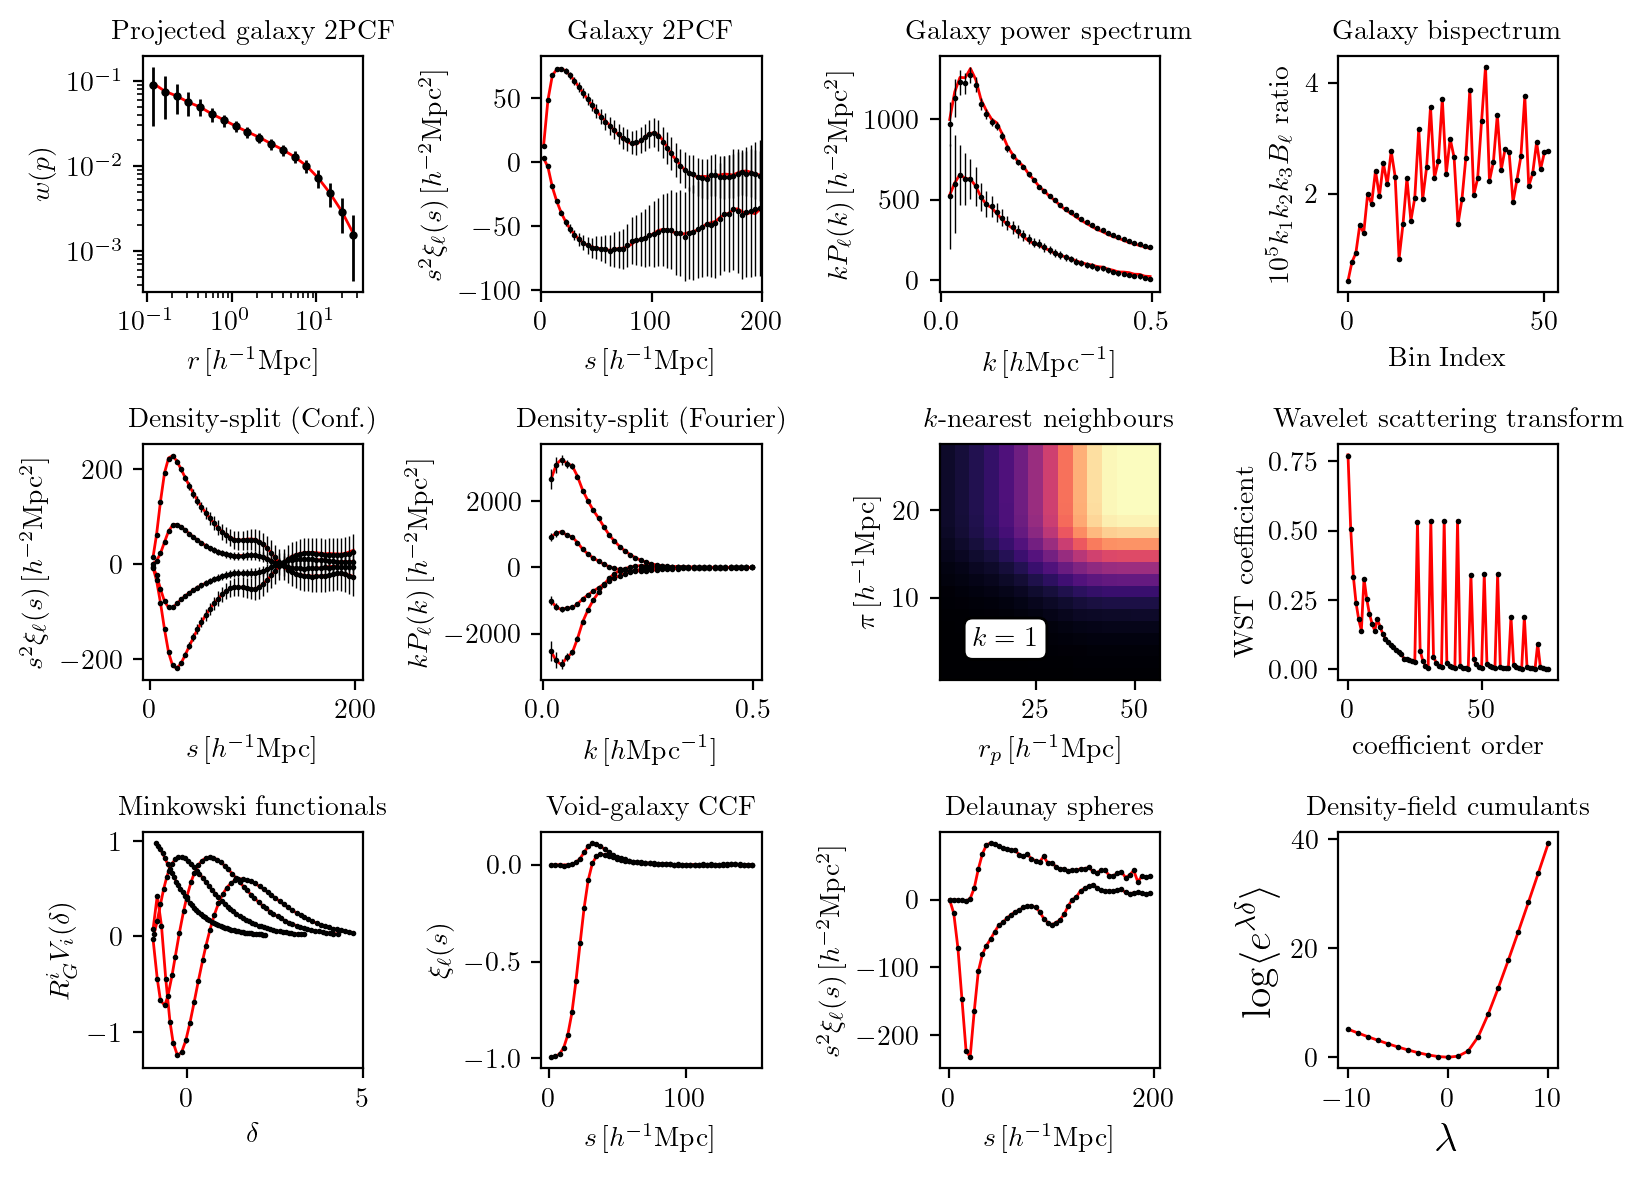

In [5]:
fig, ax = plt.subplots(3, 4, figsize=(8, 6))
hod_idx = 10

ax[0, 0].plot(wp_abs, wp_model[hod_idx], color='r', lw=1.0)
ax[0, 0].errorbar(wp_abs, wp_y[hod_idx], wp_error, marker='o', ms=2.0, ls='', color='k', elinewidth=1.0)

ax[0, 1].plot(tpcf_abs, tpcf_abs**2*tpcf_model[hod_idx, :len(tpcf_abs)], color='r', lw=1.0)
ax[0, 1].plot(tpcf_abs, tpcf_abs**2*tpcf_model[hod_idx, len(tpcf_abs):], color='r', lw=1.0)
ax[0, 1].errorbar(tpcf_abs, tpcf_abs**2*tpcf_y[hod_idx, :len(tpcf_abs)],
                  tpcf_abs**2*tpcf_error[:len(tpcf_abs)], 
                  marker='o', ms=1.0, ls='', color='k', elinewidth=0.5)
ax[0, 1].errorbar(tpcf_abs, tpcf_abs**2*tpcf_y[hod_idx, len(tpcf_abs):],
                  tpcf_abs**2*tpcf_error[len(tpcf_abs):], 
                  marker='o', ms=1.0, ls='', color='k', elinewidth=0.5)

ax[0, 2].plot(pk_abs, pk_abs*pk_model[hod_idx, :len(pk_abs)], color='r', lw=1.0)
ax[0, 2].plot(pk_abs, pk_abs*pk_model[hod_idx, len(pk_abs):], color='r', lw=1.0)
ax[0, 2].errorbar(pk_abs, pk_abs * pk_y[hod_idx, len(pk_abs):], pk_abs * pk_error[len(pk_abs):],
                  marker='o', ms=1.0, ls='', color='k', elinewidth=0.5)
ax[0, 2].errorbar(pk_abs, pk_abs * pk_y[hod_idx, :len(pk_abs)],
                  pk_abs * pk_error[:len(pk_abs)],
                  marker='o', ms=1.0, ls='', color='k', elinewidth=0.5)

weight = bk_abs.prod(axis=0)
ax[0, 3].plot(np.arange(len(weight)), weight*bk_y[hod_idx, :len(weight)]/1e5, color='r', lw=1.0, marker=None)
# ax[0, 3].plot(pk_abs, pk_abs*pk_model[hod_idx, len(pk_abs):], color='r', lw=1.0)
ax[0, 3].errorbar(np.arange(len(weight)), weight*bk_y[hod_idx, :len(weight)]/1e5, None,
                  marker='o', ms=1.0, ls='', color='k', elinewidth=0.5)
# ax[0, 3].errorbar(pk_abs, pk_abs * pk_y[hod_idx, :len(pk_abs)],
#                   pk_abs * pk_error[:len(pk_abs)],
#                   marker='o', ms=1.0, ls='', color='k', elinewidth=0.5)
ax[0, 3].set_xlabel(r'Bin Index', fontsize=10)
ax[0, 3].set_ylabel(r'$10^5k_1 k_2 k_3 B_\ell$ ratio', fontsize=10)


for q in range(4):
    ax[1, 0].plot(dsc_abs, dsc_abs**2*dsc_model[hod_idx, 2*q*len(dsc_abs):(2*q+1)*len(dsc_abs)], color='r', lw=1.0)
    ax[1, 0].errorbar(dsc_abs, dsc_abs**2*dsc_y[hod_idx, 2*q*len(dsc_abs):(2*q+1)*len(dsc_abs)],
                      dsc_abs**2*dsc_error[2*q*len(dsc_abs):(2*q+1)*len(dsc_abs)], 
                      marker='o', ms=1.0, ls='', color='k', elinewidth=0.5)
    
for q in range(4):
    ax[1, 1].plot(dscf_abs, dscf_abs*dscf_model[hod_idx, 2*q*len(dscf_abs):(2*q+1)*len(dscf_abs)], color='r', lw=1.0)
    ax[1, 1].errorbar(dscf_abs, dscf_abs*dscf_y[hod_idx, 2*q*len(dscf_abs):(2*q+1)*len(dscf_abs)],
                      dscf_abs*dscf_error[2*q*len(dscf_abs):(2*q+1)*len(dscf_abs)], 
                      marker='o', ms=1.0, ls='', color='k', elinewidth=0.5)
    
    
nbins=50 #  50 delta bins for each order of Minkowski functionals  
x = mfs_abs[0]
y = mfs_y[hod_idx] * mfs_abs[1]
y_model = mfs_model[hod_idx] * mfs_abs[1]
y_error = mfs_error * mfs_abs[1]
for i in range(4):
    ax[2, 0].plot(x[i*nbins:(i+1)*nbins],y_model[i*nbins:(i+1)*nbins], color='r', lw=1.0)
    ax[2, 0].errorbar(x[i*nbins:(i+1)*nbins], y[i*nbins:(i+1)*nbins],
                      y_error[i*nbins:(i+1)*nbins],
                  marker='o', ms=1.0, ls='', color='k', elinewidth=0.5)
    
ax[1, 3].plot(wst_abs, wst_model[hod_idx], color='r', lw=1.0)
ax[1, 3].errorbar(wst_abs, wst_y[hod_idx, :len(wst_abs)],
                  wst_error[:len(wst_abs)],
                  marker='o', ms=1.0, ls='', color='k', elinewidth=0.5)
ax[1, 3].set_xlabel('coefficient order')
ax[1, 3].set_ylabel('WST coefficient')

ax[2, 1].plot(voxel_abs, voxel_model[hod_idx, :len(voxel_abs)], color='r', lw=1.0)
ax[2, 1].plot(voxel_abs, voxel_model[hod_idx, len(voxel_abs):], color='r', lw=1.0)
ax[2, 1].errorbar(voxel_abs, voxel_y[hod_idx, :len(voxel_abs)],
                  None,
                  marker='o', ms=1.0, ls='', color='k', elinewidth=0.5)

ax[2, 1].errorbar(voxel_abs, voxel_y[hod_idx, len(voxel_abs):],
                  None,
                  marker='o', ms=1.0, ls='', color='k', elinewidth=0.5)
    
    
ax[2, 2].plot(dt_abs[::4], dt_abs[::4]**2*dt_y[hod_idx, 0, ::4],
                 marker=None, color='r', linewidth=1.0)
ax[2, 2].plot(dt_abs[::4], dt_abs[::4]**2*dt_y[hod_idx, 1, ::4],
                 marker=None, color='r', linewidth=1.0)
ax[2, 2].errorbar(dt_abs[::4], dt_abs[::4]**2*dt_y[hod_idx, 0, ::4], None,
                 marker='o', ms=1.0, ls='', color='k', elinewidth=0.5)

ax[2, 2].errorbar(dt_abs[::4], dt_abs[::4]**2*dt_y[hod_idx, 1, ::4], None,
                 marker='o', ms=1.0, ls='', color='k', elinewidth=0.5)

ax[1, 2].imshow(knn_y[hod_idx, 0], origin='lower', cmap='magma', aspect='auto',
               extent=(knn_abs[0].min(), knn_abs[0].max(), knn_abs[1].min(), knn_abs[1].max()))
ax[1, 2].text(9, 4.5, r'$k=1$', bbox={'boxstyle':'round', 'facecolor': 'w'})
ax[1, 2].set_xlabel(r'$s\,[h^{-1}{\rm Mpc}]$')
ax[1, 2].set_xlabel(r'$r_p\,[h^{-1}{\rm Mpc}]$')
ax[1, 2].set_ylabel(r'$\pi\,[h^{-1}{\rm Mpc}]$')

ax[2, 3].plot(cum_abs, cum_y, color='r', lw=1.0)
ax[2, 3].errorbar(cum_abs, cum_y, None,
                 marker='o', ms=1.0, ls='', color='k', elinewidth=0.5)
ax[2, 3].set_xlabel(r'$\lambda$', fontsize=15)
ax[2, 3].set_ylabel(r'$\log\langle e^{\lambda \delta}\rangle$', fontsize=15)

ax[0, 0].set_yscale('log')
ax[0, 0].set_xscale('log')
ax[0, 0].set_title('Projected galaxy 2PCF', fontsize=10)
ax[0, 0].set_xlabel(r'$r\,[h^{-1}{\rm Mpc}]$')
ax[0, 0].set_ylabel('$w(p$)')

ax[0, 1].set_xlabel(r'$s\,[h^{-1}{\rm Mpc}]$')
ax[0, 1].set_ylabel(r'$s^2\xi_\ell(s)\,[h^{-2}{\rm Mpc^2}]$')
ax[0, 1].set_xlim(0, 200)
ax[0, 1].set_title('Galaxy 2PCF', fontsize=10)

ax[0, 2].set_xlabel(r'$k\,[h{\rm Mpc}^{-1}]$')
ax[0, 2].set_ylabel(r'$kP_\ell(k)\,[h^{-2}{\rm Mpc^2}]$')
ax[0, 2].set_title('Galaxy power spectrum', fontsize=10)

ax[1, 0].set_xlabel(r'$s\,[h^{-1}{\rm Mpc}]$')
ax[1, 0].set_xlabel(r'$s\,[h^{-1}{\rm Mpc}]$')
ax[1, 0].set_ylabel(r'$s^2\xi_\ell(s)\,[h^{-2}{\rm Mpc^2}]$')
ax[1, 0].set_title('Density-split (Conf.)', fontsize=10)

ax[1, 1].set_xlabel(r'$k\,[h{\rm Mpc}^{-1}]$')
ax[1, 1].set_ylabel(r'$kP_\ell(k)\,[h^{-2}{\rm Mpc^2}]$')
ax[1, 1].set_title('Density-split (Fourier)', fontsize=10)

ax[2, 0].set_ylabel(r'$R_G^i V_i(\delta)$') #R_G is the gaussian smoothing scale used
ax[2, 0].set_xlabel(r'$\delta$')
ax[2, 0].set_title('Minkowski functionals', fontsize=10)

ax[2, 1].set_xlabel(r'$s\,[h^{-1}{\rm Mpc}]$')
ax[2, 1].set_ylabel(r'$\xi_\ell(s)$')
ax[2, 1].set_title('Void-galaxy CCF', fontsize=10)

ax[2, 2].set_xlabel(r'$s\,[h^{-1}{\rm Mpc}]$')
ax[2, 2].set_ylabel(r'$s^2\xi_\ell(s)\,[h^{-2}{\rm Mpc^2}]$')
ax[2, 2].set_title('Delaunay spheres', fontsize=10)

ax[0, 3].set_title('Galaxy bispectrum', fontsize=10)
ax[1, 2].set_title('$k$''-nearest neighbours', fontsize=10)
ax[1, 3].set_title('Wavelet scattering transform', fontsize=10)
ax[2, 1].set_title('Void-galaxy CCF', fontsize=10)
ax[2, 3].set_title('Density-field cumulants', fontsize=10)

plt.tight_layout()
plt.savefig('summaries_multipanel.pdf', bbox_inches='tight')
# plt.savefig('summaries_multipanel.png', bbox_inches='tight', dpi=300)
plt.show()

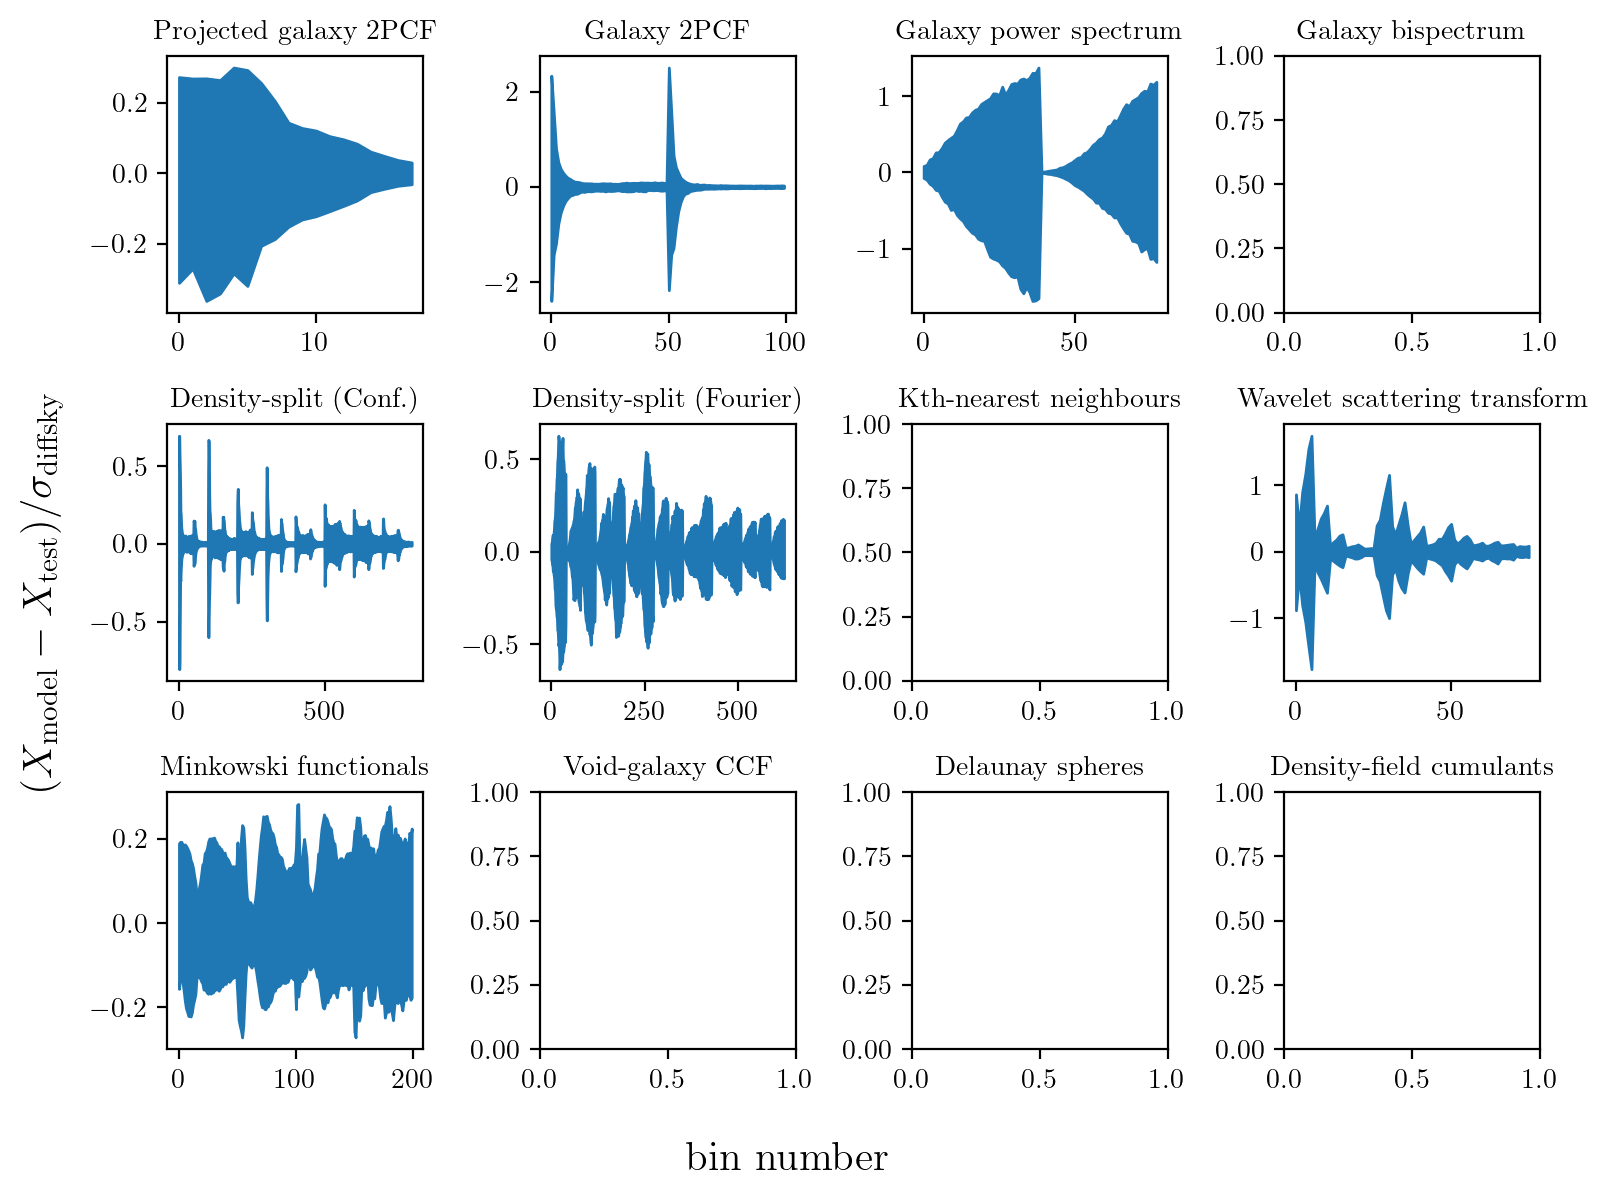

In [91]:
fig, ax = plt.subplots(3, 4, figsize=(8, 6))
# hod_idx = 10

# ax[0, 0].fill_between(
#     list(range(wp_model.shape[1])),
#     np.quantile((wp_model[:2000]-wp_y[:2000])/wp_error, [0.025, 0.975], axis=0)[0],
#     np.quantile((wp_model[:2000]-wp_y[:2000])/wp_error, [0.025, 0.975], axis=0)[1],
# )

ax[0, 0].fill_between(
    list(range(wp_model.shape[1])),
    np.quantile((wp_model[:2000]-wp_y[:2000])/wp_error, [0.16, 0.84], axis=0)[0],
    np.quantile((wp_model[:2000]-wp_y[:2000])/wp_error, [0.16, 0.84], axis=0)[1],
    color='C0',
)

ax[0, 1].fill_between(
    list(range(tpcf_model.shape[1])),
    np.quantile((tpcf_model[:2000]-tpcf_y[:2000])/tpcf_error, [0.16, 0.84], axis=0)[0],
    np.quantile((tpcf_model[:2000]-tpcf_y[:2000])/tpcf_error, [0.16, 0.84], axis=0)[1],
    color='C0',
)

ax[0, 2].fill_between(
    list(range(pk_model.shape[1])),
    np.quantile((pk_model[:2000]-pk_y[:2000])/pk_error, [0.16, 0.84], axis=0)[0],
    np.quantile((pk_model[:2000]-pk_y[:2000])/pk_error, [0.16, 0.84], axis=0)[1],
    color='C0',
)

ax[1, 0].fill_between(
    list(range(dsc_model.shape[1])),
    np.quantile((dsc_model[:2000]-dsc_y[:2000])/dsc_error, [0.16, 0.84], axis=0)[0],
    np.quantile((dsc_model[:2000]-dsc_y[:2000])/dsc_error, [0.16, 0.84], axis=0)[1],
    color='C0',
)

ax[1, 1].fill_between(
    list(range(dscf_model.shape[1])),
    np.quantile((dscf_model[:2000]-dscf_y[:2000])/dscf_error, [0.16, 0.84], axis=0)[0],
    np.quantile((dscf_model[:2000]-dscf_y[:2000])/dscf_error, [0.16, 0.84], axis=0)[1],
    color='C0',
)

ax[1, 3].fill_between(
    list(range(wst_model.shape[1])),
    np.quantile((wst_model[:2000]-wst_y[:2000])/wst_error, [0.16, 0.84], axis=0)[0],
    np.quantile((wst_model[:2000]-wst_y[:2000])/wst_error, [0.16, 0.84], axis=0)[1],
    color='C0',
)

ax[2, 0].fill_between(
    list(range(mfs_model.shape[1])),
    np.quantile((mfs_model[:2000]-mfs_y[:2000])/mfs_error, [0.16, 0.84], axis=0)[0],
    np.quantile((mfs_model[:2000]-mfs_y[:2000])/mfs_error, [0.16, 0.84], axis=0)[1],
    color='C0',
)

ax[0, 0].set_title('Projected galaxy 2PCF', fontsize=10)
ax[0, 1].set_title('Galaxy 2PCF', fontsize=10)
ax[0, 2].set_title('Galaxy power spectrum', fontsize=10)
ax[1, 0].set_title('Density-split (Conf.)', fontsize=10)
ax[1, 1].set_title('Density-split (Fourier)', fontsize=10)
ax[0, 3].set_title('Galaxy bispectrum', fontsize=10)
ax[1, 2].set_title('Kth-nearest neighbours', fontsize=10)
ax[1, 3].set_title('Wavelet scattering transform', fontsize=10)
ax[2, 0].set_title('Minkowski functionals', fontsize=10)
ax[2, 1].set_title('Void-galaxy CCF', fontsize=10)
ax[2, 2].set_title('Delaunay spheres', fontsize=10)
ax[2, 3].set_title('Density-field cumulants', fontsize=10)

# for aa in fig.axes:
#     aa.set_xlabel('bin number')
#     aa.set_ylabel('(model - test)/sigma')
#     aa.set_ylabel(r'$(X_{\rm model} - X_{\rm test})/\sigma_{\rm diffsky}$')

fig.supylabel(r'$(X_{\rm model} - X_{\rm test})/\sigma_{\rm diffsky}$', fontsize=15)
fig.supxlabel('bin number', fontsize=15)
    
# ax[0, 0].plot(wp_abs, wp_model[hod_idx], color='r', lw=1.0)
# ax[0, 0].errorbar(wp_abs, y=wp_y[hod_idx], yerr=wp_error, marker='o', ms=2.0, ls='', color='k', elinewidth=1.0)

# ax[0, 1].plot(tpcf_abs, tpcf_abs**2*tpcf_model[hod_idx, :len(tpcf_abs)], color='r', lw=1.0)
# ax[0, 1].plot(tpcf_abs, tpcf_abs**2*tpcf_model[hod_idx, len(tpcf_abs):], color='r', lw=1.0)
# ax[0, 1].errorbar(tpcf_abs, tpcf_y[hod_idx, :len(tpcf_abs)],
                  # tpcf_error[:len(tpcf_abs)], 
                  # marker='o', ms=1.0, ls='', color='k', elinewidth=0.5)
# ax[0, 1].errorbar(tpcf_abs, tpcf_abs**2*tpcf_y[hod_idx, len(tpcf_abs):],
#                   tpcf_abs**2*tpcf_error[len(tpcf_abs):], 
#                   marker='o', ms=1.0, ls='', color='k', elinewidth=0.5)

# ax[0, 0].set_yscale('log')
# ax[0, 0].set_xscale('log')
# ax[0, 0].set_title('Projected galaxy 2PCF', fontsize=10)
# ax[0, 0].set_xlabel(r'$r\,[h^{-1}{\rm Mpc}]$')
# ax[0, 0].set_ylabel('$w(p$)')

# ax[0, 1].set_xlabel(r'$s\,[h^{-1}{\rm Mpc}]$', fontsize=13)
# ax[0, 1].set_xlabel(r'$s\,[h^{-1}{\rm Mpc}]$', fontsize=13)
# ax[0, 1].set_ylabel(r'$s^2\xi_\ell(s)\,[h^{-2}{\rm Mpc^2}]$', fontsize=13)
# ax[0, 1].set_xlim(0, 200)
# ax[0, 1].set_yscale('log')
# ax[0, 1].set_title('Galaxy 2PCF multipoles', fontsize=10)

plt.tight_layout()
plt.savefig('fig/emulator_error.pdf', bbox_inches='tight')
plt.show()

Loaded LHC with shape: (10000, 12), (10000, 800)
/global/homes/e/epaillas/code/acm/projects/emc/posterior_test_emuerr_percival_dsc_conf_hod1.npy
[12.73127 15.08954 -1.07271  0.49326  0.95869  0.3343   0.77551 -0.08617
 -0.80855 -0.67385 -0.54968 -0.40783]
Removed no burn in
/global/homes/e/epaillas/code/acm/projects/emc/posterior_test_emuerr_dsc_conf_hod1.npy
[12.73127 15.08954 -1.07271  0.49326  0.95869  0.3343   0.77551 -0.08617
 -0.80855 -0.67385 -0.54968 -0.40783]
Removed no burn in


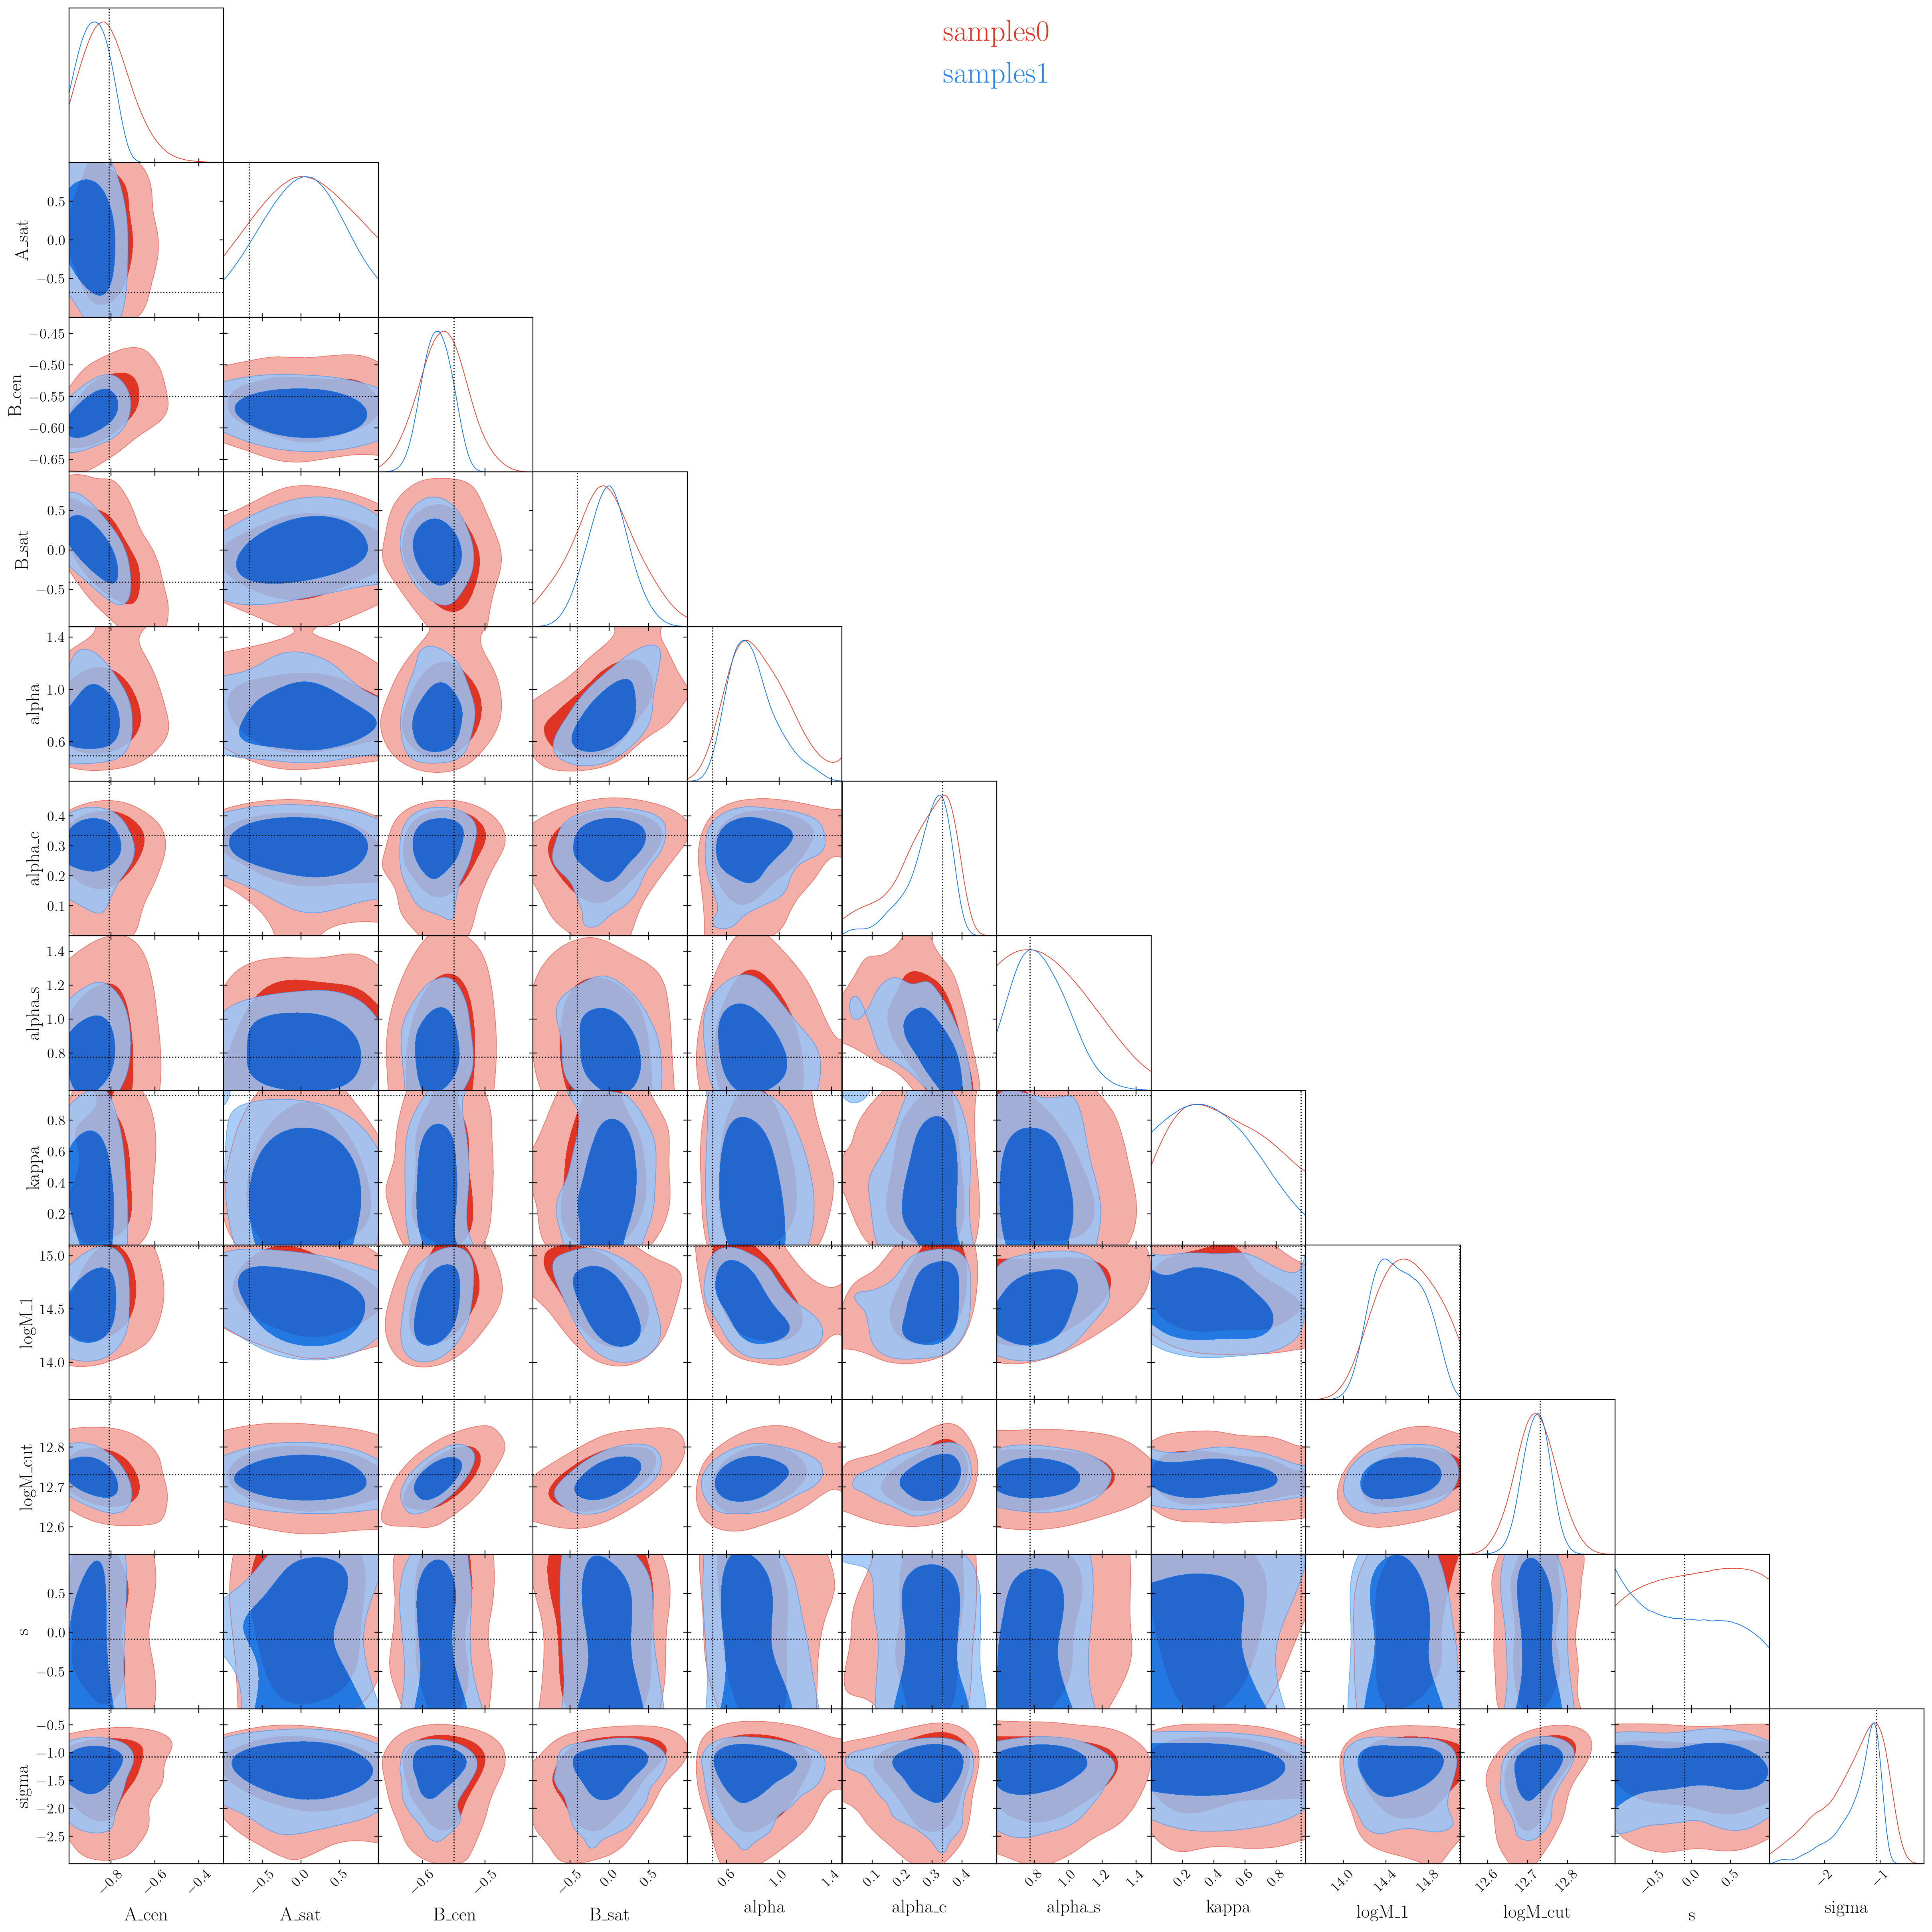

In [123]:
from getdist import plots, MCSamples
%matplotlib inline

def read_lhc(statistic='dsc_conf', n_hod=10000):
    data_dir = f'/pscratch/sd/e/epaillas/emc/training_sets/{statistic}/z0.5/yuan23_prior/c000_ph000/seed0/'
    data_fn = Path(data_dir) / f'{statistic}_lhc.npy'
    data = np.load(data_fn, allow_pickle=True).item()
    lhc_x = data['lhc_x'][:n_hod]
    lhc_y = data['lhc_y'][:n_hod]
    lhc_x_names = data['lhc_x_names']
    return lhc_x, lhc_y, lhc_x_names

def read_model(statistic):
    if statistic == 'wp':
        checkpoint_fn = f'/pscratch/sd/e/epaillas/emc/trained_models/wp/jun5_leaveout_0/last-v1.ckpt'
    if statistic == 'pk':
        checkpoint_fn = f'/pscratch/sd/e/epaillas/emc/trained_models/pk/jun25_leaveout_0/last.ckpt'
    elif statistic == 'tpcf':
        checkpoint_fn = f'/pscratch/sd/e/epaillas/emc/trained_models/tpcf/jun5_log_leaveout_0/last.ckpt'
    elif statistic == 'dsc_conf':
        checkpoint_fn = f'/pscratch/sd/e/epaillas/emc/trained_models/density_split/jun2_9_leaveout_0/last.ckpt'
    elif statistic == 'dsc_fourier':
        checkpoint_fn = f'/pscratch/sd/e/epaillas/emc/trained_models/dsc_fourier/jun24_leaveout_0/last-v1.ckpt'
    model = FCN.load_from_checkpoint(checkpoint_fn, strict=True)
    model.eval()
    return model

def read_covariance(statistic):
    data_dir = f'/pscratch/sd/e/epaillas/emc/covariance_sets/{statistic}/z0.5/yuan23_prior'
    data_fn = Path(data_dir) / f'{statistic}_cov.npy'
    y = np.load(data_fn, allow_pickle=True)
    prefactor = 1 / 8
    cov = prefactor * np.cov(y, rowvar=False)
    return cov

# stats = ['wst', 'dsc_conf', 'dsc_fourier', 'minkowski']
stats = ['dsc_conf']

idx_fit = 1

chains = []

for statistic in stats:

    # load the data
    lhc_x, lhc_y, lhc_x_names = read_lhc(statistic=statistic)
    print(f'Loaded LHC with shape: {lhc_x.shape}, {lhc_y.shape}')

    data_fn = f'/global/homes/e/epaillas/code/acm/projects/emc/posterior_test_emuerr_percival_{statistic}_hod{idx_fit}.npy'
    data = np.load(data_fn, allow_pickle=True).item()
    print(data_fn)

    print(lhc_x[idx_fit])
    
    chains.append(
        MCSamples(
                samples=data['samples'],
                weights=data['weights'],
                names=data['names'],
                ranges=data['ranges'],
            )
    )
    
    data_fn = f'/global/homes/e/epaillas/code/acm/projects/emc/posterior_test_emuerr_{statistic}_hod{idx_fit}.npy'
    data = np.load(data_fn, allow_pickle=True).item()
    print(data_fn)

    print(lhc_x[idx_fit])
    
    chains.append(
        MCSamples(
                samples=data['samples'],
                weights=data['weights'],
                names=data['names'],
                ranges=data['ranges'],
            )
    )
    
g = plots.get_subplot_plotter()
g.settings.constrained_layout = True
g.settings.axis_marker_lw = 1.0
g.settings.axis_marker_ls = ":"
g.settings.title_limit_labels = False
g.settings.axis_marker_color = "k"
g.settings.legend_colored_text = True
g.settings.figure_legend_frame = False
g.settings.linewidth_contour = 1.0
g.settings.legend_fontsize = 30
g.settings.axes_fontsize = 16
g.settings.axes_labelsize = 20
g.settings.axis_tick_x_rotation = 45
g.settings.axis_tick_max_labels = 6

g.triangle_plot(
    roots=chains,
    filled=True,
    markers=dict(zip(lhc_x_names, lhc_x[idx_fit])),
    # legend_labels=stats
)
# plt.savefig(f'fig/posterior_test_emuerr_all_hod{idx_fit}.pdf', bbox_inches='tight')

/global/homes/e/epaillas/code/acm/projects/emc/test_fixed.npy
Removed no burn in


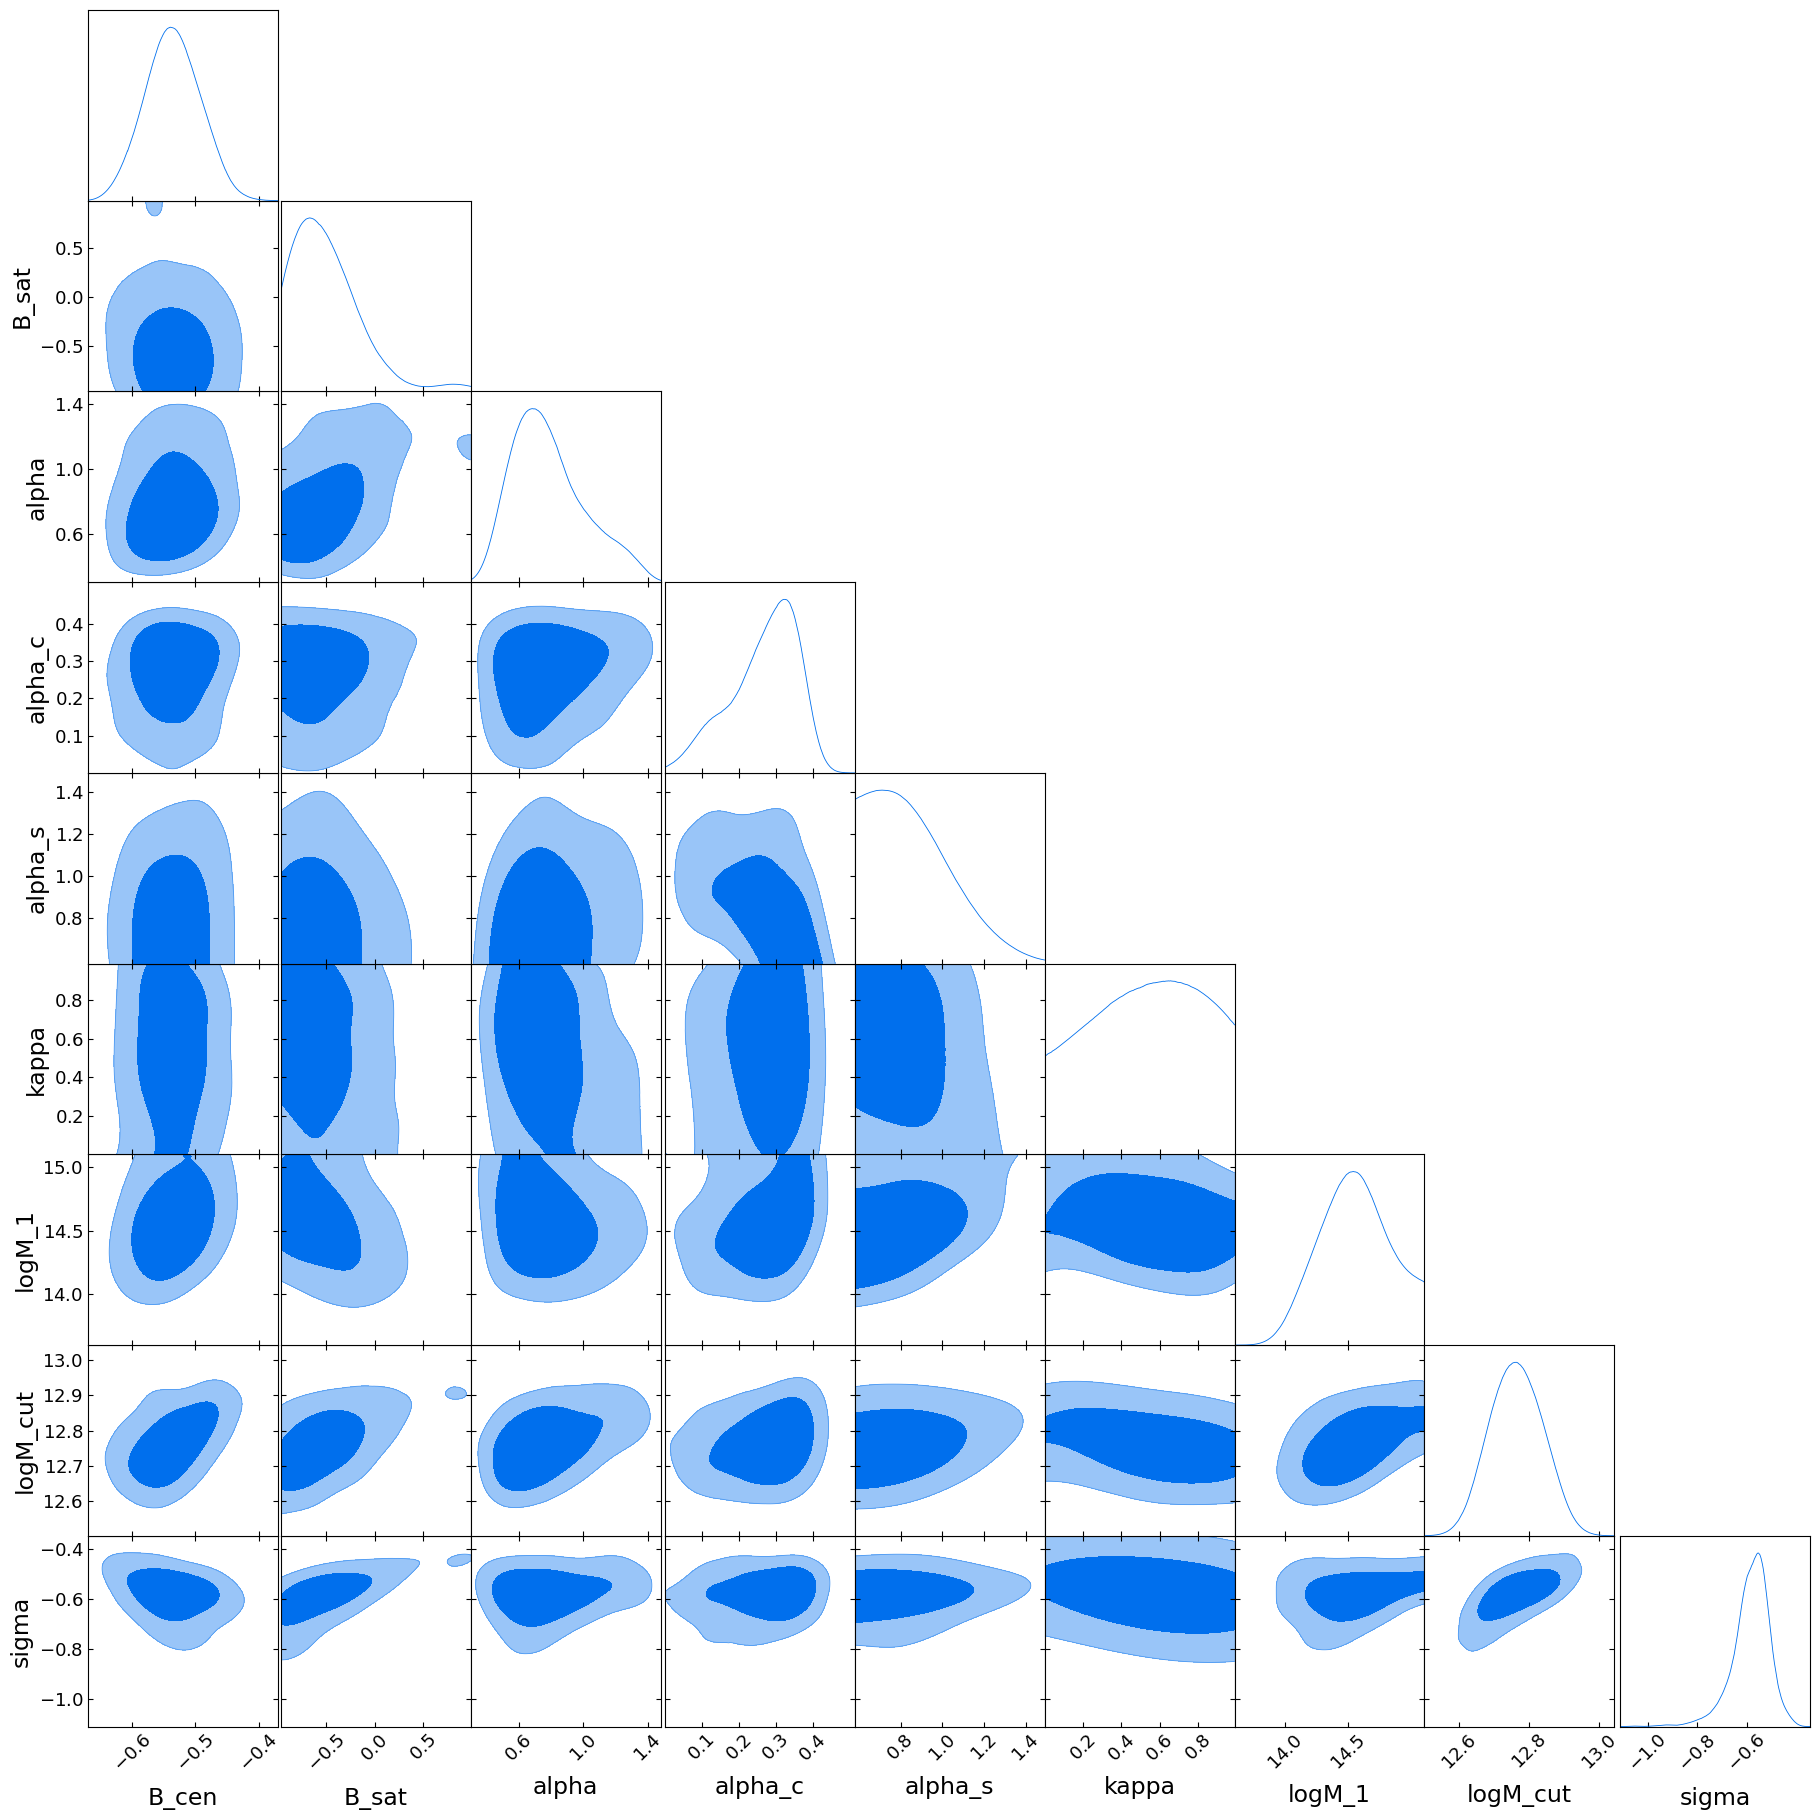

In [5]:
from getdist import plots, MCSamples
import numpy as np
%matplotlib inline

def read_lhc(statistic='dsc_conf', n_hod=10000):
    data_dir = f'/pscratch/sd/e/epaillas/emc/training_sets/{statistic}/z0.5/yuan23_prior/c000_ph000/seed0/'
    data_fn = Path(data_dir) / f'{statistic}_lhc.npy'
    data = np.load(data_fn, allow_pickle=True).item()
    lhc_x = data['lhc_x'][:n_hod]
    lhc_y = data['lhc_y'][:n_hod]
    lhc_x_names = data['lhc_x_names']
    return lhc_x, lhc_y, lhc_x_names

def read_model(statistic):
    if statistic == 'wp':
        checkpoint_fn = f'/pscratch/sd/e/epaillas/emc/trained_models/wp/jun5_leaveout_0/last-v1.ckpt'
    if statistic == 'pk':
        checkpoint_fn = f'/pscratch/sd/e/epaillas/emc/trained_models/pk/jun25_leaveout_0/last.ckpt'
    elif statistic == 'tpcf':
        checkpoint_fn = f'/pscratch/sd/e/epaillas/emc/trained_models/tpcf/jun5_log_leaveout_0/last.ckpt'
    elif statistic == 'dsc_conf':
        checkpoint_fn = f'/pscratch/sd/e/epaillas/emc/trained_models/density_split/jun2_9_leaveout_0/last.ckpt'
    elif statistic == 'dsc_fourier':
        checkpoint_fn = f'/pscratch/sd/e/epaillas/emc/trained_models/dsc_fourier/jun24_leaveout_0/last-v1.ckpt'
    model = FCN.load_from_checkpoint(checkpoint_fn, strict=True)
    model.eval()
    return model

def read_covariance(statistic):
    data_dir = f'/pscratch/sd/e/epaillas/emc/covariance_sets/{statistic}/z0.5/yuan23_prior'
    data_fn = Path(data_dir) / f'{statistic}_cov.npy'
    y = np.load(data_fn, allow_pickle=True)
    prefactor = 1 / 8
    cov = prefactor * np.cov(y, rowvar=False)
    return cov


idx_fit = 1

chains = []


data_fn = f'/global/homes/e/epaillas/code/acm/projects/emc/test_fixed.npy'
data = np.load(data_fn, allow_pickle=True).item()
print(data_fn)


chains.append(
    MCSamples(
            samples=data['samples'],
            weights=data['weights'],
            names=data['names'],
            ranges=data['ranges'],
        )
)
    
    
g = plots.get_subplot_plotter()
g.settings.constrained_layout = True
g.settings.axis_marker_lw = 1.0
g.settings.axis_marker_ls = ":"
g.settings.title_limit_labels = False
g.settings.axis_marker_color = "k"
g.settings.legend_colored_text = True
g.settings.figure_legend_frame = False
g.settings.linewidth_contour = 1.0
g.settings.legend_fontsize = 30
g.settings.axes_fontsize = 16
g.settings.axes_labelsize = 20
g.settings.axis_tick_x_rotation = 45
g.settings.axis_tick_max_labels = 6

g.triangle_plot(
    roots=chains,
    filled=True,
    # markers=dict(zip(lhc_x_names, lhc_x[idx_fit])),
    # legend_labels=stats
)
# plt.savefig(f'fig/posterior_test_emuerr_all_hod{idx_fit}.pdf', bbox_inches='tight')